<a href="https://colab.research.google.com/github/khoinguyen0999/Housing-price-prediction/blob/main/ML_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Gỉai nén file zip và đọc file csv bên trong.

In [3]:
from google.colab import files
uploaded = files.upload()
import zipfile
import pandas as pd
zip_file = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_file) as z:
  print(z.namelist())
  csv_file = z.namelist()[0]
  with z.open(csv_file) as f:
      data = pd.read_csv(f)
print(data.head())


Saving archive (3).zip to archive (3) (1).zip
['Housing.csv']
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  


Nhận xét: không có missing values và duplicates

In [8]:
print(data.isnull().sum())
print(data.duplicated().sum())


price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64
0


loại bỏ giá trị ngoại lai

In [76]:
Q1 = data['price'].quantile(0.25)
Q2 = data['price'].quantile(0.75)
IQR = Q2 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q2 + 1.5 * IQR
rows_to_keep_index = data[(data['price'] >= lower_bound) & (data['price'] <= upper_bound)].index
data_clean = data.loc[rows_to_keep_index].reset_index(drop=True)
print(data_clean.head())

     price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  9100000  6000         4          1        2      yes        no      yes   
1  9100000  6600         4          2        2      yes       yes      yes   
2  8960000  8500         3          2        4      yes        no       no   
3  8890000  4600         3          2        2      yes       yes       no   
4  8855000  6420         3          2        2      yes        no       no   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no              no        2       no   semi-furnished  
1              no             yes        1      yes      unfurnished  
2              no             yes        2       no        furnished  
3              no             yes        2       no        furnished  
4              no             yes        1      yes   semi-furnished  


Encode các kiểu dữ liệu categorical bằng label encoding cho yes/no và onehotencoding cho furnishingstatus

In [79]:
yes_no = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
data_processed = data_clean.copy()
for col in yes_no:
    data_processed[f'{col}_encoded'] = data_processed[col].apply(lambda x: 1 if str(x).strip().lower() == 'yes' else 0)
data_processed = data_processed.drop(columns=yes_no)
data_encoded = pd.get_dummies(data_processed, columns = ['furnishingstatus'], drop_first = True)
furnishing_dummies = [col for col in data_encoded.columns if 'furnishingstatus_' in col]
data_encoded[furnishing_dummies] = data_encoded[furnishing_dummies].astype(int)
yes_no_encoded_cols = [f'{col}_encoded' for col in yes_no]
data_encoded[yes_no_encoded_cols] = data_encoded[yes_no_encoded_cols].astype(int)
rename_dict = {f'{col}_encoded': col for col in yes_no}
data_encoded = data_encoded.rename(columns=rename_dict)
print(data_encoded.head())

     price  area  bedrooms  bathrooms  stories  parking  mainroad  guestroom  \
0  9100000  6000         4          1        2        2         1          0   
1  9100000  6600         4          2        2        1         1          1   
2  8960000  8500         3          2        4        2         1          0   
3  8890000  4600         3          2        2        2         1          1   
4  8855000  6420         3          2        2        1         1          0   

   basement  hotwaterheating  airconditioning  prefarea  \
0         1                0                0         0   
1         1                0                1         1   
2         0                0                1         0   
3         0                0                1         0   
4         0                0                1         1   

   furnishingstatus_semi-furnished  furnishingstatus_unfurnished  
0                                1                             0  
1                             

Rescale features để mô hình học tốt hơn (data preprocessing)

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
data_encoded[features] = scaler.fit_transform(data_encoded[features])
print(data_encoded[features])

         area  bedrooms  bathrooms   stories   parking
15   0.452609  1.447749  -0.561254  0.245614  1.585532
16   0.741976  1.447749   1.594286  0.245614  0.398622
17   1.658306  0.077558   1.594286  2.570175  1.585532
18  -0.222581  0.077558   1.594286  0.245614  1.585532
19   0.655166  0.077558   1.594286  0.245614  0.398622
..        ...       ...        ...       ...       ...
540 -0.994226 -1.292633  -0.561254 -0.916667  1.585532
541 -1.283593  0.077558  -0.561254 -0.916667 -0.788287
542 -0.695214 -1.292633  -0.561254 -0.916667 -0.788287
543 -1.037631  0.077558  -0.561254 -0.916667 -0.788287
544 -0.584290  0.077558  -0.561254  0.245614 -0.788287

[530 rows x 5 columns]


Biểu đồ phân phối price lệch sang trái => dữ liệu phân phối chuẩn

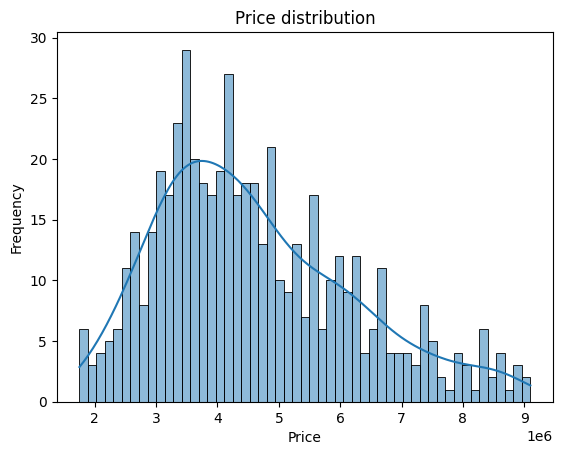

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(data_encoded['price'], kde = True, bins = 53)
plt.title('Price distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

giá thành và sự hiện diện của các biến đại diện cho phòng, hộp true (1) có mean luôn cao hơn false (0) => chúng đồng biến với nhau. Đồng thời không còn giá trị ngoại lai.

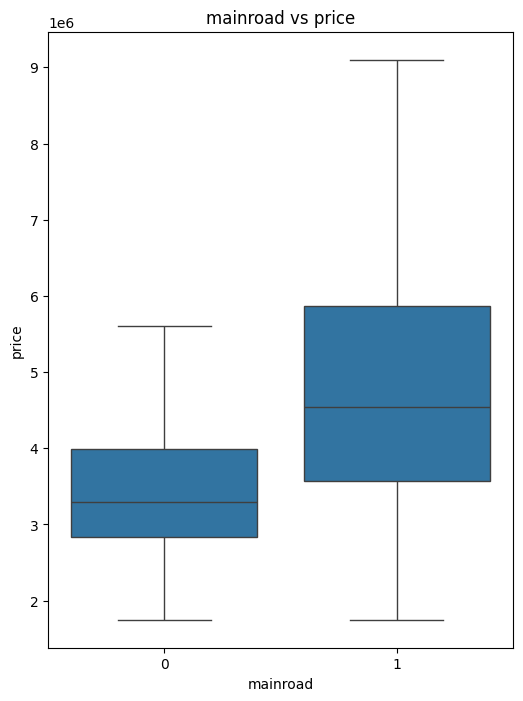

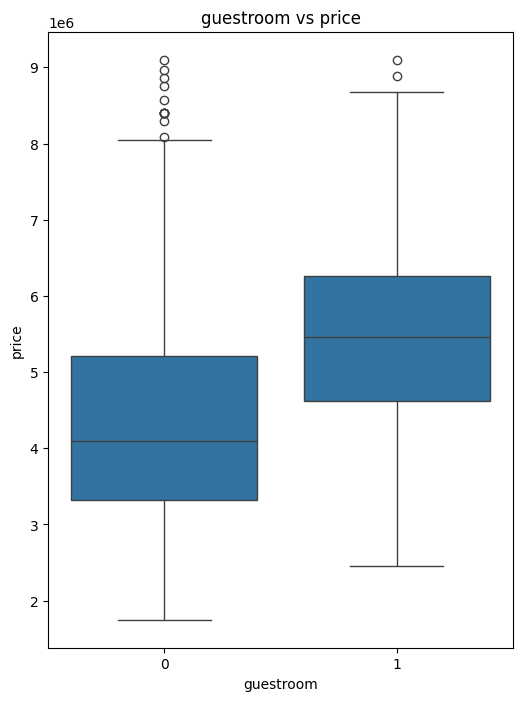

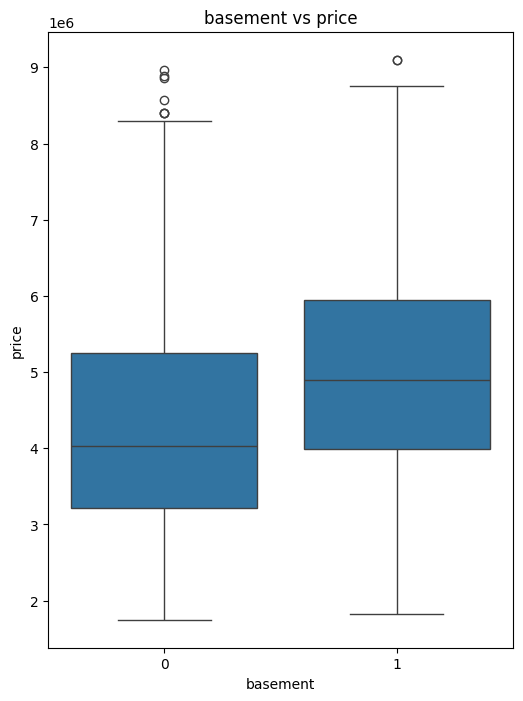

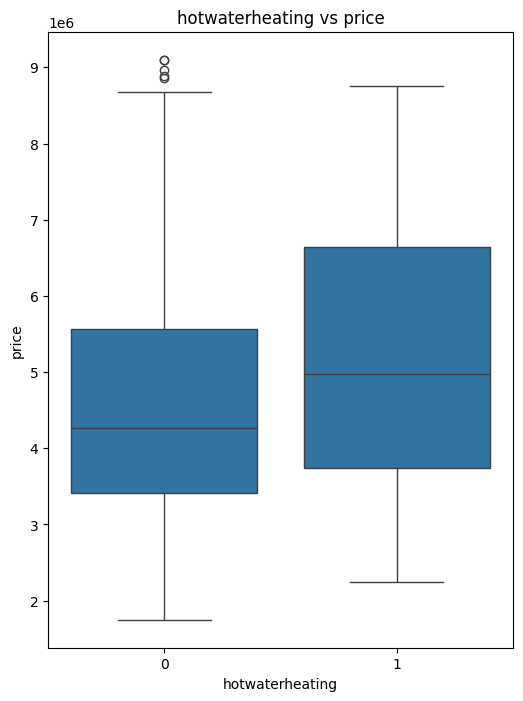

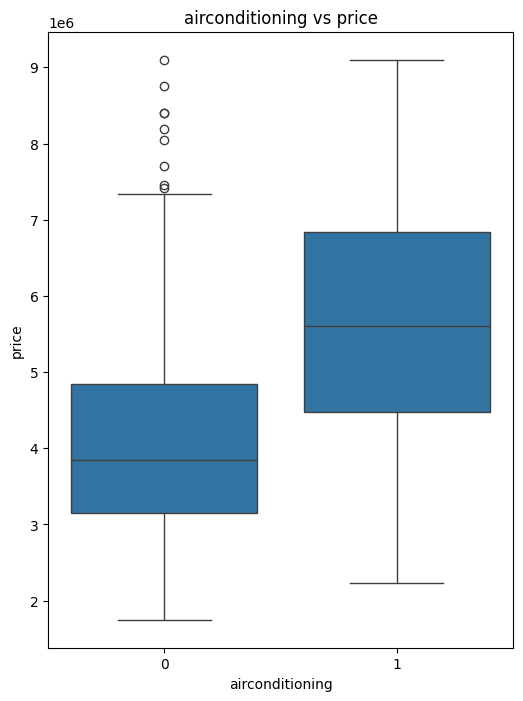

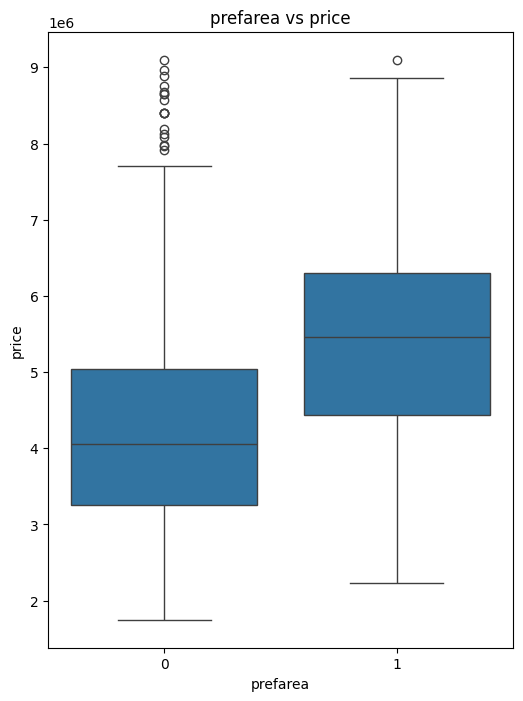

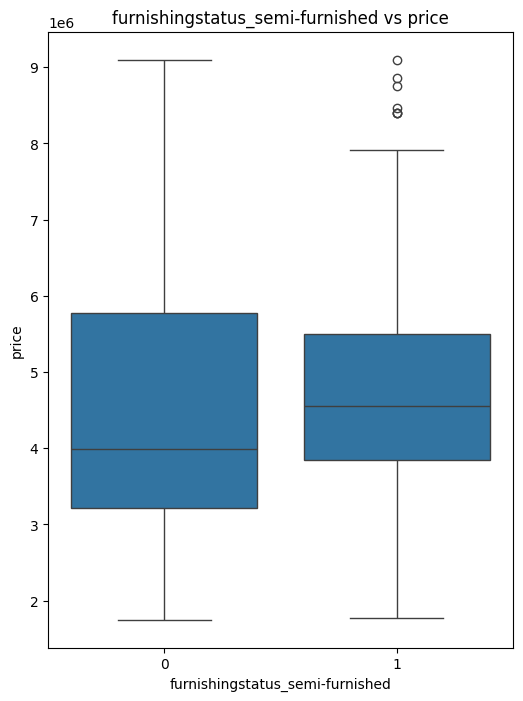

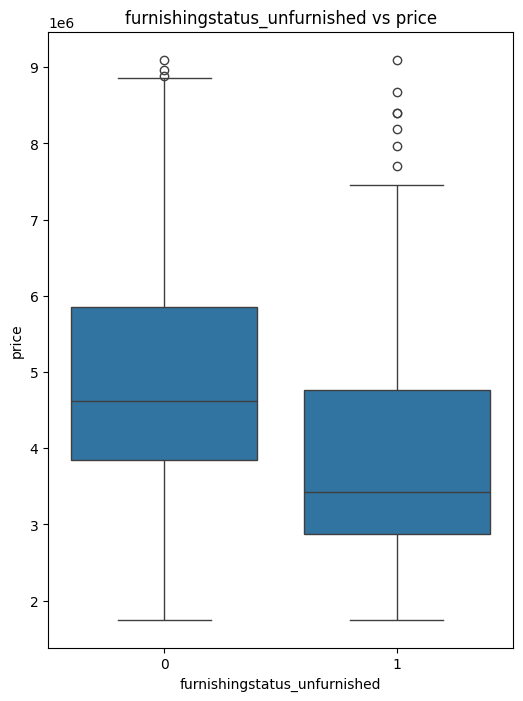

In [28]:
categorical = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished']
for col in categorical:
  plt.figure(figsize = (6, 8))
  sns.boxplot(x = col, y = 'price', data = data_encoded)
  plt.title(f'{col} vs price')
  plt.show()

Nhận xét: các mối quan hệ tương quan khá mạnh mẽ và luôn đồng biến nhau

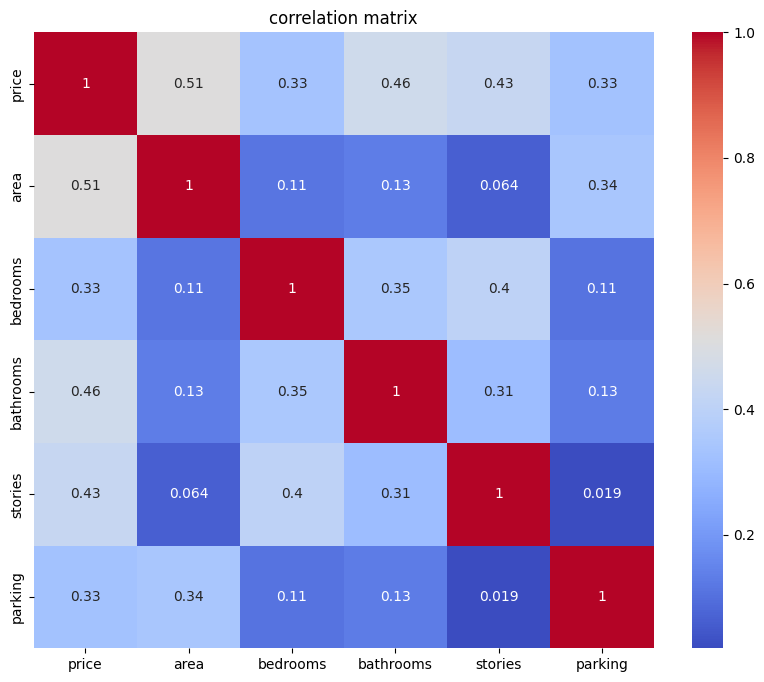

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 8))
data_hmp = data_encoded.drop(categorical, axis = 1)
sns.heatmap(data_hmp.corr(), annot = True, cmap = 'coolwarm')
plt.title('correlation matrix')
plt.show()

In [ ]:
data_encoded['sum_area'] = data_encoded['area'] * data_encoded['stories']
yes_no = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
data_encoded['amenities_count'] = data_encoded[yes_no].sum(axis=1)
print(data_encoded.head())

Huấn luyện mô hình bằng XGB regression, log-transformation và dùng rmse, r2_score đánh giá độ chính xác mô hình

In [80]:
#tách features và target
from sklearn.model_selection import train_test_split
import numpy as np
X = data_encoded.drop('price', axis = 1)
y = np.log1p(data_encoded['price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
#model training
from xgboost import XGBRegressor
y_train_log = y_train
y_test_log = y_test
model = XGBRegressor(n_estimators = 500, learning_rate = 0.03, max_depth = 5, subsample = 0.8, colsample_bytree = 0.8, random_state = 42)
model.fit(X_train, y_train_log)
#model evaluation
from sklearn.metrics import mean_squared_error, r2_score
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_orig = np.expm1(y_test_log)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
r2 = r2_score(y_test_orig, y_pred)
print(rmse)
print(r2)

1097779.504815231
0.6519630022303463


biểu đồ kết quả cuối cùng

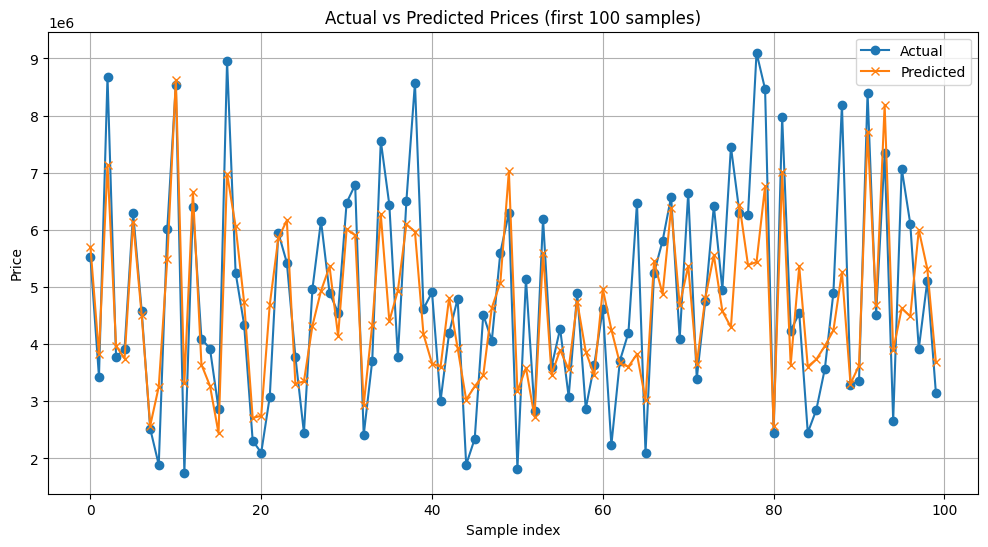

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test_orig.values[:100], label='Actual', marker='o')
plt.plot(y_pred[:100], label='Predicted', marker='x')
plt.xlabel('Sample index')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices (first 100 samples)')
plt.legend()
plt.grid(True)
plt.show()